# WZE-UAV Image Classification using Deep Learning

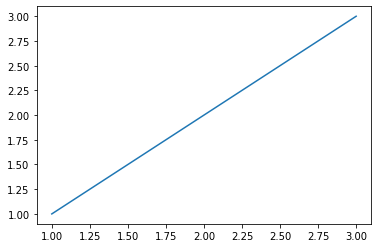

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import mlxtend
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


x = (1,3)
y = (1,3)
plt.plot(x,y)

In [2]:
import torch
import torchvision.transforms as T
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchinfo import summary
from torchmetrics import *
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from mlxtend.plotting import plot_confusion_matrix
import h5py

In [3]:
import wze_uav.data_loader as data_loader
import wze_uav.visualization as visualization
import wze_uav.models as models
from wze_uav.engine import *
from wze_uav.utils2 import *
from wze_uav.log_writer import create_writer

#### Get PyTorch version

In [4]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


#### Preparing device agnostic code 

In [5]:
# ensure device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# get index of currently selected device
print(f"Index of current divice: {torch.cuda.current_device()}")
# get number of GPUs available
print(f"Number of GPUs available: {torch.cuda.device_count()}")
# get the name of the device
print(f"GPU Model: {torch.cuda.get_device_name(0)}")

cuda
Index of current divice: 0
Number of GPUs available: 1
GPU Model: Quadro RTX 8000


#### Ensure reproducibility 

In [6]:
# for more information, see also: https://pytorch.org/docs/stable/notes/randomness.html

# Set seeds
def set_seeds(seed: int=0):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 0.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# seed for numpy
np.random.seed(0)
# avoiding non-deterministic algorithms
#torch.use_deterministic_algorithms(True)
# Set to true -> might speed up the process but should be set to False if reproducible results are desired
torch.backends.cudnn.benchmark = True


#### Define file directories

In [7]:
set_seeds() # ensure reproducibility

data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit"

test_data_path = r""

#### Create hashID for spatial seperation of the data

In [ ]:
fn_list = os.listdir(data_path)
# Initialize dictionary to store groups of files with the same name
file_groups = {}

# Iterate over all datafiles
for year in fn_list:
    year_dir = f'{data_path}\\{year}'
    for filename in os.listdir(year_dir):
        # Generate unique identifier for file based on its name
        identifier = hashlib.md5(filename.encode()).hexdigest()

        # Add file to appropriate group based on identifier
        if identifier in file_groups:
            file_groups[identifier][year] = os.path.join(year_dir, filename)
        else:
            file_groups[identifier] = {year: os.path.join(year_dir, filename)}

#### Prepare k-folds for cross validation

In [ ]:
data_dict = file_groups

# create lists of hashIDs and file paths
hashIDs = []
file_paths = []
for hashID, files in data_dict.items():
    for year, file_path in files.items():
        hashIDs.append(hashID)
        file_paths.append(file_path)

# define the number of folds for k-fold cross-validation
num_folds = 5

# create the k-fold cross-validator with GroupKFold
kf = GroupKFold(n_splits=num_folds)      

#### Define model and parameters

In [ ]:
# set seeds
g = torch.Generator()
g.manual_seed(0)

###### define Parameters######
NUM_WORKERS=3 # should be changed, depending on the system used
batch_size=16
n_bands = 3 # define number of bands
num_classes = len(classes)
dropout_rate = 0.3 #define dropout rate
unfreeze = True
gamma = 0.65 # how fast the learning rate decreases per epoch (low number=faster decrease)
weights = 2 # weight for the focal loss to give more importance to the minority classes
#step_size = 1
##############################


classes = train_dataset.class_names
num_classes = len(classes) # get output_shape (number of classes) as an argument for the model


# train transform with augmentation. 
transform_train = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5), transforms.RandomRotation(degrees=[-90,90])])

# test and val dataset transform without augmentation. 
transform = transforms.Compose([transforms.ToTensor()])


#class names need to fit the customDataset class used e.g. 3 classes -> use CustomDataset3Classes
#class_names = ['healthy', 'slightly_stressed', 'moderately_stressed', 'highly_stressed', 'dead']
#class_names = ['healthy', 'moderately_stressed', 'highly_stressed', 'dead']
class_names = ['healthy', 'stressed', 'dead']

# Define number of epochs per fold
num_epochs = num_epochs

# Create target folder name were to save the tensorboard event files
target_dir = "TEST_log_evaluation"

#### Perform k-fold cross validation and run the model

In [ ]:
%%time
set_seeds()
# group files with same names from each year based on their hashID to ensure spatial seperation of train and validation data
for fold, (train_idx, val_idx) in enumerate(kf.split(file_paths, groups=hashIDs)): 
    # get the train and validation file paths using the indices
    train_files = [file_paths[i] for i in train_idx]
    val_files = [file_paths[i] for i in val_idx]
   
    train_image_set, train_label_set, train_species_set, train_kkl_set, train_bk_set = data_loader.hdf5_to_img_label(train_files, load_sets = ["images_masked"])
    val_image_set, val_label_set, val_species_set, val_kkl_set, val_bk_set = data_loader.hdf5_to_img_label(val_files, load_sets = ["images_masked"])
    
    # create PyTorch dataset - choose custom dataset loader with 3 - 5 classes
    train_dataset = data_loader.CustomDataset3Classes(data = train_image_set, labels = train_label_set, class_names=class_names, species = train_species_set, kkl = train_kkl_set, transform=transform_train)
    val_dataset = data_loader.CustomDataset3Classes(data = val_image_set, labels = val_label_set, class_names=class_names, species = val_species_set, kkl = val_kkl_set, transform=transform)
     
    # create sampler to handle class imbalance by oversampling the minority classes - will be used as argument in the train_dataloader
    sampler = data_loader.data_sampler(labels_tensor=train_dataset.labels, class_names=class_names)
    
    # create PyTorch dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, persistent_workers=True, pin_memory=True, num_workers=NUM_WORKERS, generator=g, sampler=sampler, shuffle=False, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, persistent_workers=True, pin_memory=True, num_workers=NUM_WORKERS, shuffle=False, drop_last=True)
    
    # set the initial learning rate
    lr = 0.005
    
    model = create_effnetb2(output_shape=num_classes, dropout_rate=0.3, unfreeze=True, device=device)
    model_name = "Fold_" + str(fold) + "_EffNet_b2"

    # Create loss and optimizer
    loss_fn = FocalLoss(weights=weights)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    lr_scheduler = ExponentialLR(optimizer, gamma=gamma)
    
    # Loop through each number of epochs within the fold
    for epochs in num_epochs:
    
        # Create information print outs
        experiment_number += 1
        print(f"[INFO] K-fold: {fold}")
        print(f"[INFO] Model: {model_name}")
        print(f"[INFO] Number of epochs: {epochs}")
        print(f"[INFO] Batch_size: {batch_size}")
        print(f"[INFO] Number of bands: {n_bands}")
        print(f"[INFO] Dropout rate: {dropout_rate}")
        print(f"[INFO] Gamma learning rate: {gamma}")
        print(f"[INFO] Gamma FocalLoss: {weights}")
        
        # Train target model with target dataloaders and track experiments
        results = train(model=model,
                        model_name=model_name,
                        n_bands=n_bands,
                        batch_size=batch_size,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader, 
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        lr_scheduler=lr_scheduler,
                        num_classes=num_classes,
                        epochs=epochs,
                        device=device,
                        writer=create_writer(target_dir=target_dir,
                                             experiment_name='Evaluating_hyperparameters',
                                             model_name=model_name,
                                             extra=f"{fold}_fold_{epochs}_epochs"))
        
        # 10. Save the model to file so we can get back the best model
        save_filepath = f"01_{model_name}_{epochs}_epochs.pth"
        save_model(model=model,
                   target_dir="finished_models",
                   model_name=save_filepath)
        print("-"*50 + "\n")


[INFO] Experiment number: 1
[INFO] Model: effnet_b0
[INFO] Number of epochs: 20
[INFO] Batch_size: 16
[INFO] Number of bands: 3
[INFO] Dropout rate: 0.3
[INFO] Gamma learning rate: 0.65
[INFO] Gamma FocalLoss: 2
[INFO] Created new effnet_b0 model.
[INFO] Created SummaryWriter, saving to: TEST_log_evaluation\2023-03-29\Evaluating_hyperparameters\effnet_b0\20_epochs...


  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate: 0.005
Epoch: 1 
Train loss: 0.2624 | Train precision: 0.6566 | Train recall: 0.6441 | Train f1score: 0.5644 | Train acc: 0.5865 
Val loss: 0.4467 | Val precision: 0.7400 | Val recall: 0.3993 | Val f1score: 0.2868 | Val acc: 0.5076 

Learning rate: 0.005
Epoch: 2 
Train loss: 0.2162 | Train precision: 0.6950 | Train recall: 0.6915 | Train f1score: 0.6277 | Train acc: 0.6252 
Val loss: 0.1991 | Val precision: 0.8084 | Val recall: 0.6648 | Val f1score: 0.5962 | Val acc: 0.6674 

Learning rate: 0.005
Epoch: 3 
Train loss: 0.2082 | Train precision: 0.7041 | Train recall: 0.7095 | Train f1score: 0.6507 | Train acc: 0.6477 
Val loss: 0.2792 | Val precision: 0.8189 | Val recall: 0.5549 | Val f1score: 0.4953 | Val acc: 0.7410 

Learning rate: 0.005
Epoch: 4 
Train loss: 0.2015 | Train precision: 0.7245 | Train recall: 0.7250 | Train f1score: 0.6755 | Train acc: 0.6651 
Val loss: 0.1810 | Val precision: 0.8115 | Val recall: 0.6890 | Val f1score: 0.6186 | Val acc: 0.6562 

Learning

In [ ]:
# create test dataset
test_dataset = data_loader.CustomDataset3Classes(
    data = test_image_set,
    labels = test_label_set,
    class_names=class_names, 
    species = test_species_set,
    kkl = test_kkl_set,
    transform=transform
)

# create test dataloader
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             persistent_workers=True,
                             pin_memory=True,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             drop_last=True)

In [60]:
# Setup the best model filepath
best_model_path = r"C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\effnet_b0\01_18_epochs.pth"

# Instantiate a new instance of EffNetB0 (to load the saved state_dict() to)
unfreeze=True
best_model = models.create_effnetb0(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnet_b0 model.


<All keys matched successfully>

In [61]:
def make_predictions(model: torch.nn.Module, 
                     test_dataloader: torch.utils.data.DataLoader,
                     device: torch.device):
    # 1. Make predictions with trained model
    y_preds = []
    y_labels = []
    test_loss, test_precision, test_recall, test_f1_score, test_acc = 0, 0, 0, 0, 0
    count = 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader, desc="Making predictions"):
            # Send data and targets to target device
            X, y = X.to(device), y.to(device)
            # Do the forward pass
            y_logit = model(X)
            # Turn predictions from logits -> prediction probabilities -> predictions labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())
            y_labels.append(y.cpu())
            
            #other metrics
            test_acc += ((y_pred == y).sum().item()/len(y_pred))
            y_pred_class = y_pred.detach().cpu().numpy() 
            y_class = y.detach().cpu().numpy()
            labels = np.array([0])
            test_precision += precision_score(y_class, y_pred_class, average='macro', zero_division=0, labels=[0,1,2])
            test_recall += recall_score(y_class, y_pred_class, average='macro', zero_division=0, labels=[0,1,2])
            #test_f1_score += f1_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
            
            #if count >= 1:
            #    y_set = torch.cat((y_set, y))
            #    count = count + 1
            #else:
            #    y_set = y
            #    count = count + 1
            
    test_loss = test_loss / len(test_dataloader)
    test_precision = test_precision / len(test_dataloader)
    test_recall = test_recall / len(test_dataloader)
    test_f1_score = test_f1_score / len(test_dataloader)
    #test_kappa = test_kappa / len(dataloader)
    test_acc = test_acc / len(test_dataloader)
    # Concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)
    y_labels_tensor = torch.cat(y_labels)
    test_f1_score = f1_score(y_labels_tensor.detach().cpu().numpy(), y_pred_tensor.cpu().numpy(), average='macro', zero_division=1, labels=[0,1,2])
    
    # Print classification report
    y_true = y_labels_tensor.detach().cpu().numpy()
    report = classification_report(y_true, y_pred_tensor.cpu().numpy(), target_names=class_names)
    print(report)
    
    return y_pred_tensor, y_labels_tensor, test_loss, test_recall, test_precision, test_f1_score, test_acc, y_logit, y_pred, y, y_preds

Making predictions:   0%|          | 0/156 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     healthy       0.95      0.88      0.92      2228
    stressed       0.32      0.56      0.41       226
        dead       0.84      0.86      0.85        42

    accuracy                           0.85      2496
   macro avg       0.70      0.77      0.72      2496
weighted avg       0.89      0.85      0.87      2496

Test loss: 0.0
Test precision: 0.4154684139459786
Test recall: 0.41671078506014464
Test F1score: 0.7247865216737815
Test Accuracy: 0.8525641025641025
Test Logits: tensor([[ 1.7014,  0.8877, -5.1889],
        [ 2.3632,  0.8889, -6.1630],
        [ 2.2219,  0.9962, -6.0906],
        [-0.6744,  0.1306,  0.6790],
        [ 0.9584,  1.0023, -4.1342],
        [ 1.1653,  0.9413, -4.2456],
        [ 1.9196,  1.0043, -5.6535],
        [ 0.5722,  0.7214, -2.7888],
        [ 2.0116,  1.1527, -6.1480],
        [ 2.0599,  1.0727, -6.0320],
        [ 2.1480,  0.9218, -5.8122],
        [ 1.8820,  0.8687, -5.2790],
        [ 1.

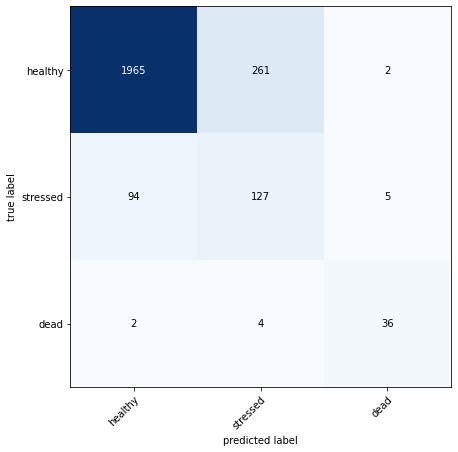

In [62]:
# 2. Setup confusion matrix instance and compare predictions to targets
#from wze_uav.analysis import *
y_pred_tensor, y_labels_tensor, test_loss, test_recall, test_precision, test_f1_score, test_acc, y_logit, y_pred, y, y_preds = make_predictions(model=best_model,
                                 test_dataloader=test_dataloader, 
                                 device=device)

y_labels_tensor = y_labels_tensor.detach().cpu().numpy()
y_pred_tensor = y_pred_tensor.detach().cpu().numpy()

#confmat = ConfusionMatrix(num_classes=num_classes, task='multiclass')
#confmat_tensor = confmat(preds=y_pred_tensor,
#                         target=test_labels)
labels = np.array([0,1,2])
confmat = confusion_matrix(y_labels_tensor, y_pred_tensor, labels=labels)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat, # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

print(f"Test loss: {test_loss}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1score: {test_f1_score}")
#print(f"Test Kappa: {test_kappa}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Logits: {y_logit}")
print(f"Test Predictions: {y_pred}")
print(f"Test Labels: {y}")

In [48]:
len(y_preds)

156

In [92]:
y_set.cpu()

NameError: name 'y_set' is not defined

In [141]:
test_dataset.labels

tensor([1, 0, 1,  ..., 0, 0, 0])

In [139]:
y_preds = []
y_labels = []
labels = np.array([0,1,2])
test_loss, test_precision, test_recall, test_f1_score, test_acc = 0, 0, 0, 0, 0
count = 0
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        y_labels.append(y.cpu())
        
        #other metrics
        test_acc += ((y_pred == y).sum().item()/len(y_pred))
        y_pred_class = y_pred.detach().cpu().numpy() 
        y_class = y.detach().cpu().numpy()
        test_precision += precision_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        test_recall += recall_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        #test_f1_score += f1_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        
        #if count >= 1:
        #    y_set = torch.cat((y_set, y))
        #    count = count + 1
        #else:
        #    y_set = y
        #    count = count + 1
        
test_loss = test_loss / len(test_dataloader)
test_precision = test_precision / len(test_dataloader)
test_recall = test_recall / len(test_dataloader)
#test_f1_score = test_f1_score / len(test_dataloader)
#test_kappa = test_kappa / len(dataloader)
test_acc = test_acc / len(test_dataloader)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
test_f1_score = f1_score(y_set.detach().cpu().numpy(), y_pred_tensor.cpu().numpy(), average='macro', zero_division=0, labels=[0,1,2])

# Print classification report
y_true = y_set.detach().cpu().numpy()
report = classification_report(y_true, y_pred_tensor.cpu().numpy(), target_names=class_names)
print(report)

Making predictions:   0%|          | 0/156 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     healthy       0.94      0.90      0.92      2228
    stressed       0.42      0.31      0.35       226
        dead       0.19      0.83      0.32        42

    accuracy                           0.85      2496
   macro avg       0.52      0.68      0.53      2496
weighted avg       0.88      0.85      0.86      2496



In [140]:
test_f1_score

0.528680154128826

In [122]:
make = (y_class == y_pred_class)
make

array([ True,  True,  True, False,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True])

In [99]:
torch.softmax(y_logit, dim=1).argmax(dim=1)

tensor([0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [101]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [112]:
test = (y_pred == y).sum().item()/16

In [113]:
test

0.8125

In [114]:
 y_pred_class = y_pred.detach().cpu().numpy() 

In [115]:
y_pred_class

array([0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)